# **Генерация лиц с AAE**

## Загрузка библиотек

In [3]:
import os

# !pip install natsort -q
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset

import numpy as np
import itertools

import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image

import torch.nn as nn
import torch

import matplotlib.pyplot as plt

## Подготовка данных

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_root = '/kaggle/input/celeba-dataset'

# Путь к папке с данными
dataset_folder = f'{data_root}/img_align_celeba'

In [9]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images
        transform (callable, optional): transform to be applied to each image sample
        """
        # Считываем название файлов
        image_names = os.listdir(root_dir)

        self.root_dir = root_dir
        self.transform = transform 
        self.image_names = natsorted(image_names)
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Получаем путь к файлу
        img_path = os.path.join(self.root_dir, self.image_names[idx])
        # Загружаем изображение
        img = Image.open(img_path).convert('RGB')
        # Применяем преобразования
        if self.transform:
            img = self.transform(img)
        return img

## Загружаем датасет 
# Путь к директории со всеми изображениями
img_folder = f'{dataset_folder}/img_align_celeba'
# Фиксируем размер изображения
image_size = 128
# Преоьразования
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

celeba_dataset = CelebADataset(img_folder, transform)

batch_size = 128
pin_memory = True if DEVICE.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(
    celeba_dataset,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    pin_memory=pin_memory,
    shuffle=True
)

In [4]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = (image.transpose((1,2,0)) + 1) / 2
    return image

def plot_img(data, idx):
    plt.figure(figsize=(5, 5))
    img = data.__getitem__(idx)
    image = image_convert(img)
    plt.imshow(image)
    plt.show()

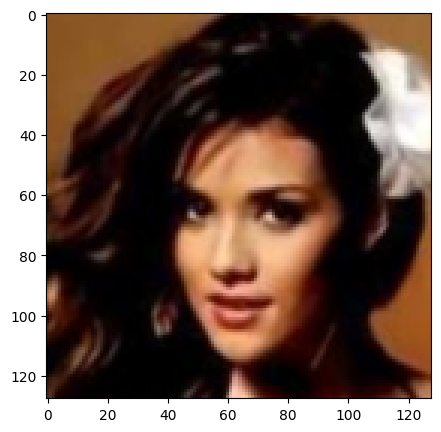

In [21]:
# Выберем рандомный индекс и выведем изображение из датасета
random_image_idx = np.random.choice(range(len(celeba_dataset)))
plot_img(celeba_dataset, random_image_idx)

## Модель

In [10]:
n_epochs = 10
lr = 0.0002
b1, b2 = 0.5, 0.999
channels = 3
latent_dim = 10
sample_interval = 400

img_shape = (channels, image_size, image_size)

def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = torch.tensor(np.random.normal(0, 1, (mu.size(0), latent_dim)), device=DEVICE)
    z = sampled_z * std + mu
    return z


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity


# Функция потерь
adversarial_loss = torch.nn.BCELoss()
pixelwise_loss = torch.nn.L1Loss()

# Инициализируем генератор и дискриминатор
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

encoder.to(DEVICE)
decoder.to(DEVICE)
discriminator.to(DEVICE)
adversarial_loss.to(DEVICE)
pixelwise_loss.to(DEVICE)


# Оптимизаторы
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits"""
    z = torch.tensor(np.random.normal(0, 1, (n_row ** 2, latent_dim)), dtype=torch.float32, device=DEVICE)
    gen_imgs = decoder(z)
    save_image(gen_imgs.data, "%d.png" % batches_done, nrow=n_row, normalize=True)

## Обучение модели 

In [9]:
REP_FREQ = (len(celeba_dataloader) // 2)

for epoch in range(n_epochs):
    for i, imgs in enumerate(celeba_dataloader):
        valid = torch.ones(imgs.shape[0], 1, dtype=torch.float32, device=DEVICE)
        fake = torch.zeros(imgs.shape[0], 1, dtype=torch.float32, device=DEVICE)
       
        real_imgs = imgs.to(DEVICE)
        
        # -----------------
        #  Генератор
        # -----------------

        optimizer_G.zero_grad()
        
        encoded_imgs = encoder(real_imgs).float()
        decoded_imgs = decoder(encoded_imgs).float()

        g_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) + 0.999 * pixelwise_loss(
            decoded_imgs, real_imgs
        )

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Дискриминатор
        # ---------------------

        optimizer_D.zero_grad()

        z = torch.tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)), dtype=torch.float32, device=DEVICE)

        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
        if i % REP_FREQ == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(celeba_dataloader), d_loss.item(), g_loss.item())
            )

        batches_done = epoch * len(celeba_dataloader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)

[Epoch 0/10] [Batch 0/1583] [D loss: 0.696876] [G loss: 0.580912]
[Epoch 0/10] [Batch 791/1583] [D loss: 0.594306] [G loss: 0.224006]
[Epoch 0/10] [Batch 1582/1583] [D loss: 0.518850] [G loss: 0.234413]
[Epoch 1/10] [Batch 0/1583] [D loss: 0.583249] [G loss: 0.216010]
[Epoch 1/10] [Batch 791/1583] [D loss: 0.529865] [G loss: 0.220752]
[Epoch 1/10] [Batch 1582/1583] [D loss: 0.556819] [G loss: 0.229994]
[Epoch 2/10] [Batch 0/1583] [D loss: 0.583821] [G loss: 0.215045]
[Epoch 2/10] [Batch 791/1583] [D loss: 0.529553] [G loss: 0.214068]
[Epoch 2/10] [Batch 1582/1583] [D loss: 0.576028] [G loss: 0.213221]
[Epoch 3/10] [Batch 0/1583] [D loss: 0.526539] [G loss: 0.224843]
[Epoch 3/10] [Batch 791/1583] [D loss: 0.618023] [G loss: 0.213562]
[Epoch 3/10] [Batch 1582/1583] [D loss: 0.590472] [G loss: 0.219723]
[Epoch 4/10] [Batch 0/1583] [D loss: 0.532137] [G loss: 0.222094]
[Epoch 4/10] [Batch 791/1583] [D loss: 0.582681] [G loss: 0.210834]
[Epoch 4/10] [Batch 1582/1583] [D loss: 0.529768] [G l

In [1]:
from IPython.display import Image

# Image("TrainingGIF.gif")

Сохраняем параметры модели.

In [16]:
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'gen_optim_state_dict': optimizer_G.state_dict(),
    'disc_state_dict': discriminator.state_dict(),
    'disc_optim_state_dict': optimizer_D.state_dict()
}, 'final_AAE_params.pth')

## Анализ скрытого пространства признаков

Decoder(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=49152, bias=True)
    (6): Tanh()
  )
)


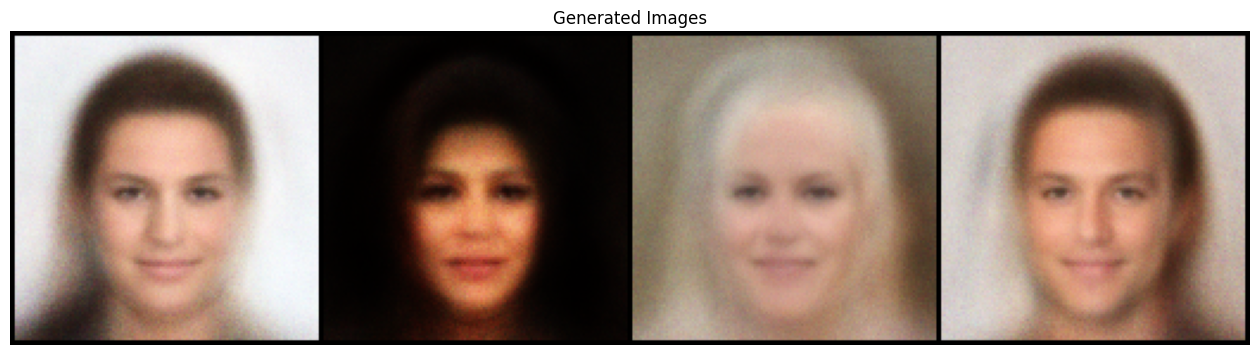

In [22]:
# Загрузка чекпоинта
state_dict = torch.load('./final_AAE_params.pth', map_location=DEVICE)

# Генератор
aaeG = Decoder().to(DEVICE)
# Загрузка весов генератора
aaeG.load_state_dict(state_dict['decoder_state_dict'])
print(aaeG)

# Зададим число изображений
n_imgs = 4
# Получим латентный вектор из равномерного нормального распределения
mu = torch.randn(n_imgs, latent_dim, device=DEVICE)
logvar = torch.randn(n_imgs, latent_dim, device=DEVICE)

z = reparameterization(mu, logvar).float()

with torch.no_grad():
	# Получим сгенерированное изображение
    generated_img = aaeG(z).detach().cpu()

    # Скейлинг от[-1,1] к [0,1]
    generated_img = (generated_img+ 1) / 2.0

# Выведим на экран сгенерированные изображения
plt.figure(figsize = (16, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1, 2, 0)));

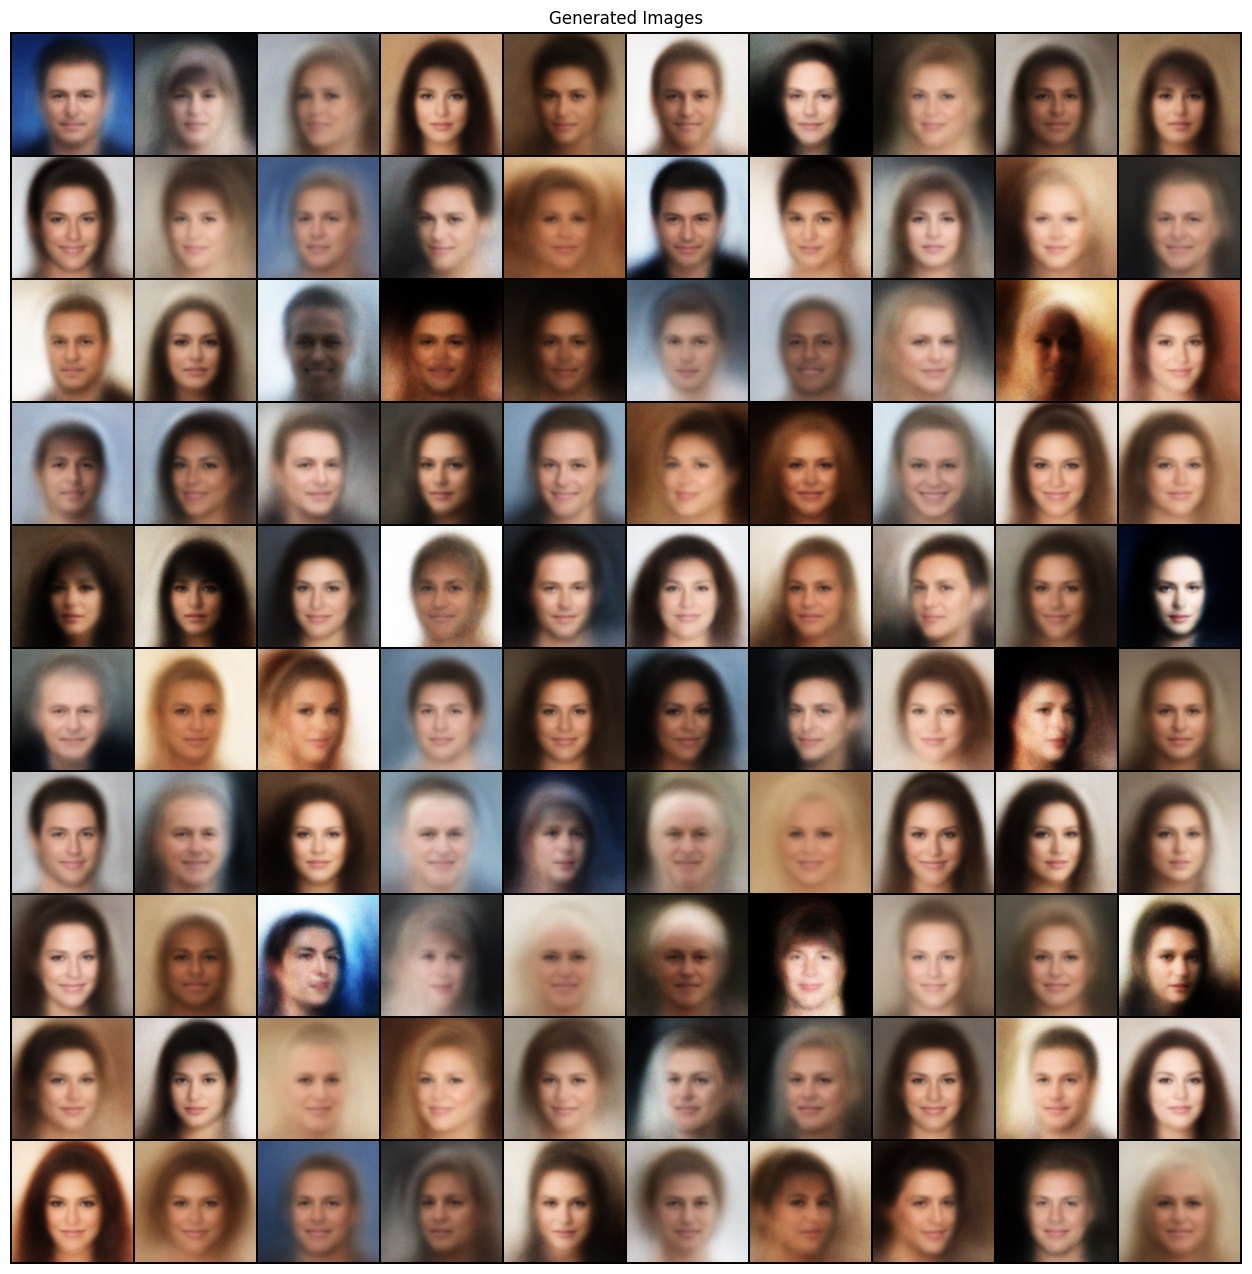

In [34]:
from torchvision.utils import  make_grid

num_options = 100
batch_size = 100
generated_imgs = []
latent_vectors = []
padding = 2

for i in range(num_options // batch_size):  # Предполагая num_options делится на batch_size
    mu = torch.randn(batch_size, latent_dim, device=DEVICE)
    logvar = torch.randn(batch_size, latent_dim, device=DEVICE)
    z = reparameterization(mu, logvar).float()  
    
    with torch.no_grad():
        generated_img = aaeG(z).detach()
    
    generated_imgs.append(generated_img)
    latent_vectors.append(z.detach().cpu())

# Объединение изображений
stacked_tensor_imgs = torch.cat(generated_imgs).view(-1, channels, image_size, image_size)
final_tensor_img = make_grid(stacked_tensor_imgs, nrow=int(np.sqrt(num_options)), padding=padding, normalize=True)
display_img = np.moveaxis(final_tensor_img.numpy(), 0, 2)

plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(display_img);

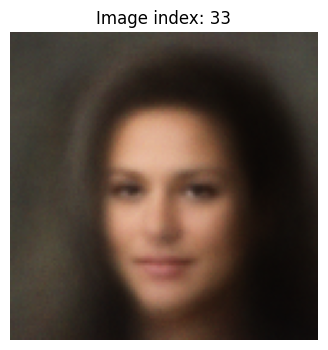

In [169]:
img_idx = 33
plt.figure(figsize = (4, 4))
plt.axis("off")
plt.title(f"Image index: {img_idx}")
plt.imshow((np.moveaxis(stacked_tensor_imgs[img_idx].numpy(), 0, 2) + 1) / 2);

In [143]:
# Выделим индексы интересующих нас изображений
black_haired_woman_ix = [3, 4, 6, 10, 33, 40, 41, 42, 68, 81]
white_haired_woman_ix = [1, 2, 7, 11, 14, 18, 27, 66, 74, 99]
black_haired_man_ix = [0, 5, 15, 20, 22, 25, 30, 60, 76, 88]

In [144]:
black_haired_woman_latent_vectors = [latent_vectors[0][i].numpy() for i in black_haired_woman_ix]
white_haired_woman_latent_vectors = [latent_vectors[0][i].numpy() for i in white_haired_woman_ix]
black_haired_man_latent_vectors = [latent_vectors[0][i].numpy() for i in black_haired_man_ix]

In [145]:
# Рассчитаем усредненный латентный вектор для каждой категории 
black_haired_woman_avg_latent_vector = np.mean(np.array(black_haired_woman_latent_vectors), axis=0)
white_haired_woman_avg_latent_vector = np.mean(np.array(white_haired_woman_latent_vectors), axis=0)
black_haired_man_avg_latent_vector = np.mean(np.array(black_haired_man_latent_vectors), axis=0)

In [146]:
white_haired_man_latent_vector = black_haired_man_avg_latent_vector + (
    white_haired_woman_avg_latent_vector - black_haired_woman_avg_latent_vector
    )

In [158]:
with torch.no_grad():
    # Обработка беловолосых женщин
    white_haired_woman_latent_tensor = torch.stack([torch.Tensor(latent_vector) for latent_vector in white_haired_woman_latent_vectors]).cpu()
    white_haired_women_imgs = aaeG(white_haired_woman_latent_tensor).numpy()
    
    # Обработка черноволосых женщин
    black_haired_woman_latent_tensor = torch.stack([torch.Tensor(latent_vector) for latent_vector in black_haired_woman_latent_vectors]).cpu()
    black_haired_women_imgs = aaeG(black_haired_woman_latent_tensor).numpy()
    
    # Обработка черноволосых мужчин
    black_haired_man_latent_tensor = torch.stack([torch.Tensor(latent_vector) for latent_vector in black_haired_man_latent_vectors]).cpu()
    black_haired_men_imgs = aaeG(black_haired_man_latent_tensor).numpy()

    # Обработка средних изображений
    batch_size = 4
    white_haired_woman_avg_img = aaeG(torch.Tensor(white_haired_woman_avg_latent_vector).repeat(batch_size, 1))
    black_haired_woman_avg_img = aaeG(torch.Tensor(black_haired_woman_avg_latent_vector).repeat(batch_size, 1))
    black_haired_man_avg_img = aaeG(torch.Tensor(black_haired_man_avg_latent_vector).repeat(batch_size, 1))
    white_haired_man_img = aaeG(torch.Tensor(white_haired_man_latent_vector).repeat(batch_size, 1))

Светловолосая женщина


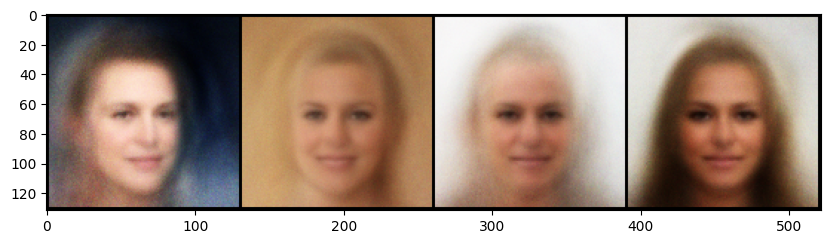

In [159]:
plt.figure(figsize = (10,10))
print('Светловолосая женщина')
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(white_haired_women_imgs[-4:]), padding=2, normalize=True, nrow=10), (1,2,0)));

Темноволосая женщина


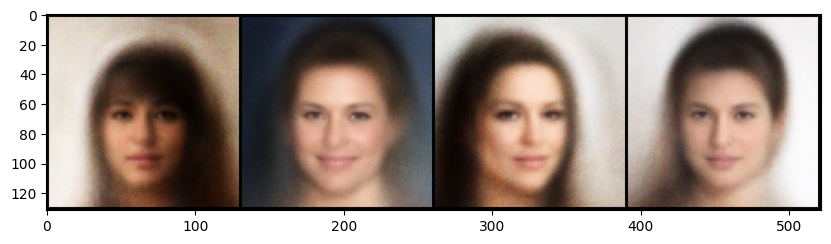

In [160]:
plt.figure(figsize = (10,10))
print('Темноволосая женщина')
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(black_haired_women_imgs[-4:]), padding=2, normalize=True, nrow=10), (1, 2, 0)));

Темноволосый мужчина


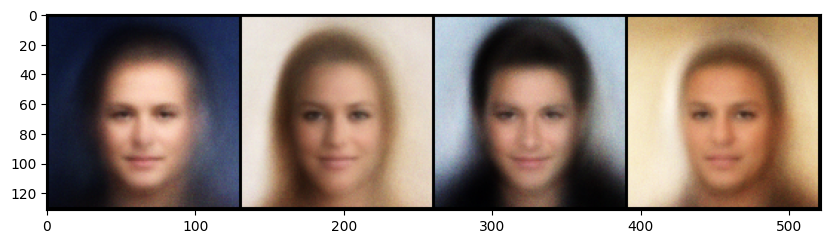

In [161]:
plt.figure(figsize = (10,10))
print('Темноволосый мужчина')
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(black_haired_men_imgs[:4]), padding=2, normalize=True, nrow=10), (1, 2, 0)));

Здесь мы уже видим предвестник грядущей проблемы: нам уже сложновато понять пол по изображениям. 

Резултьтат: светловолосый мужчина...


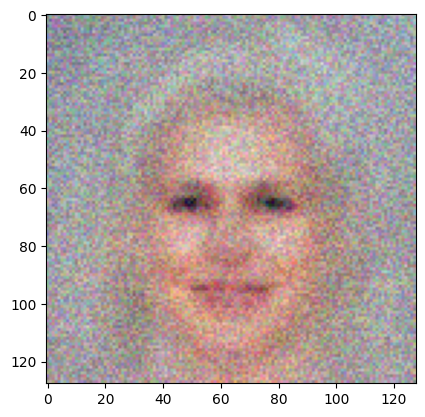

In [170]:
print('Резултьтат: светловолосый мужчина...')

plt.imshow(np.transpose(
    vutils.make_grid(
        torch.Tensor(white_haired_man_img[0]),
        padding=2, normalize=True, nrow=10
        ),
    (1, 2, 0)
    ));

И здесь мы сталкиваемся с проблемой экстракции целевого признака из латентного пространства: векторная арифметика не помогла нам вычленить интересующие нас характеристики.

Возможное решение: нам либо нужно попробовать обучить модель с большим размером скрытого пространства, либо изменить архитектуру сетей, либо уже на имеющемся сейчас сгенерировать несколько сотен изображений и долго искать релевантные экземпляры.

И все же общее качество изображений у MLP AAE оказалось выше, чем у DC GAN.